### 第三部分、数据分析部分

通过pymysql将mysql数据库中下载的数据引入，利用pandas进行分析，并运用matplotlib对数据分析进行可视化。

In [19]:
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt

In [74]:
conn = pymysql.connect(host='127.0.0.1', port=3306, user ='root', passwd= "2003", db = "blogs_summer", charset="utf8" )
#cursor=conn.cursor()
sql='SELECT blogid,writerFan,writerThumb,blog_read_count,time,cpp,csharp,java,javascript,php,sqll,python FROM `blog_bloginfo`;'
df=pd.read_sql(sql,conn)

d:\Desktop\comingSpring\meworker\python_yeah\ana\envs\py38\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


连接到本地数据库并读取所需要的数据。

#### 一、博客数目随时间变化及推送算法中博客热度与时间关系探究

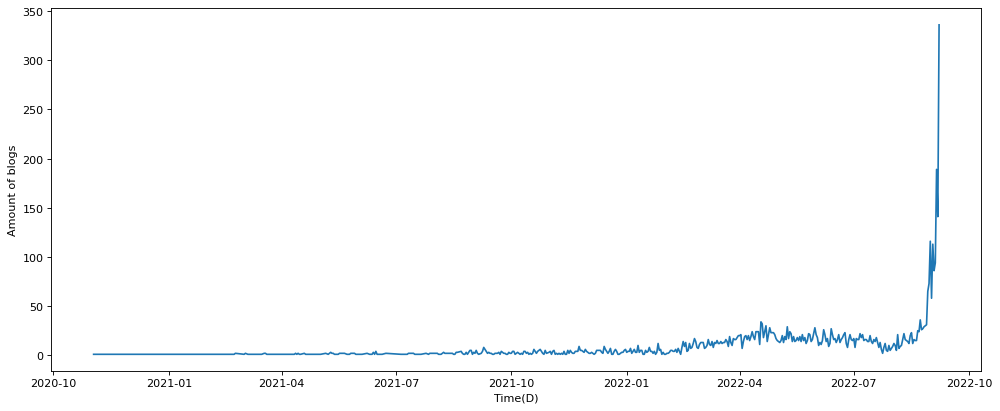

datetime
2020-11-02      1
2020-12-06      1
2021-01-05      1
2021-01-11      1
2021-01-26      1
             ... 
2022-09-03     86
2022-09-04     94
2022-09-05    189
2022-09-06    141
2022-09-07    336
Name: blogid, Length: 487, dtype: int64
Mean of blogsnum:  10.470225872689939


In [85]:
df["datetime"]=df['time'].dt.date
data=df[pd.notnull(df['datetime'])]
grouped = data.groupby(by='datetime').count()['blogid']
x=grouped.index
y=grouped.values
plt.figure(figsize=(15,6),dpi=80)
plt.xlabel('Time(D)')
plt.ylabel('Amount of blogs')
plt.plot(x,y)
plt.show()
print(grouped)
print("Mean of blogsnum: ",grouped.values.mean())

由上图可发现，csdn首页推送算法最为青睐当天更新的博客，因此在爬取数据当天爬取到的博客最多，并在最近几天呈现出断层优势。

不过同时可以发现往前在2022年2-8月之间博客数量也比较可观，说明该首页推送并不只推送近段时间的内容，还会依照其他的标准推送时间比较远的博客（乃至两年前）。具体的标准我们可以继续通过数据加以推测。

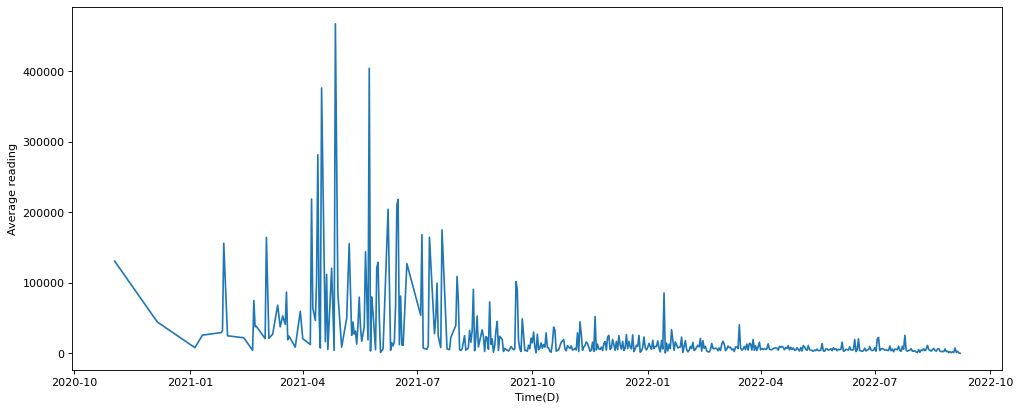

In [86]:
grouped1 = data.blog_read_count.groupby(by=data['datetime']).mean()
x=grouped1.index
y=grouped1.values
plt.figure(figsize=(15,6),dpi=80)
plt.xlabel('Time(D)')
plt.ylabel('Average reading')
plt.plot(x,y)

分析不同时间的博客平均阅读数量，有一个直观的特点为离现在时间较近的博客平均阅读量较低，而被推送到的时间较久的博客平均阅读量会相对较高。但这张折线图或许掩盖了群体特点（取了平均数），因此我们作散点图再来看看。

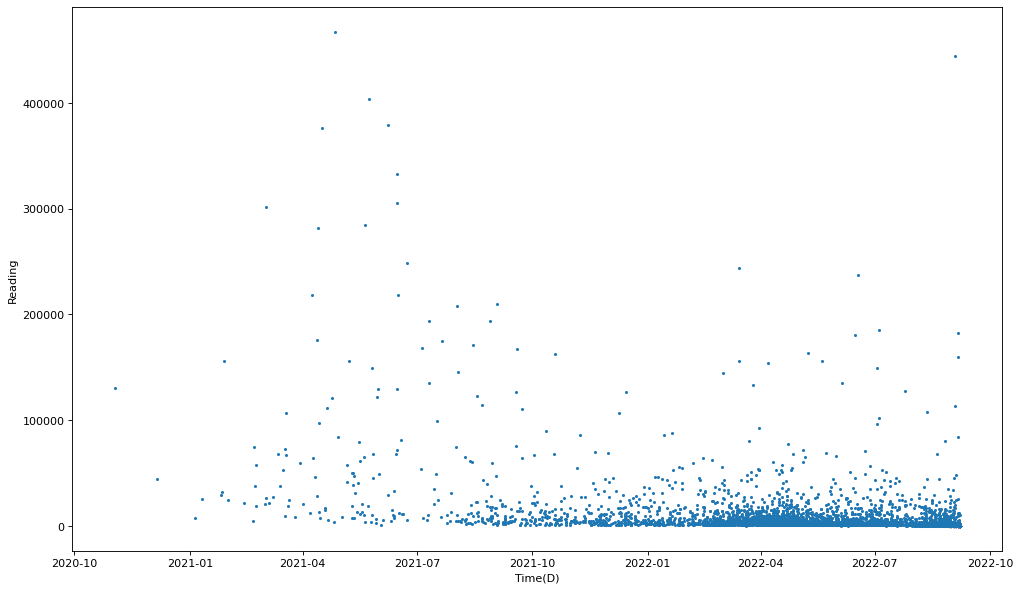

In [90]:
x=data.datetime
y=data.blog_read_count
plt.figure(figsize=(15,9),dpi=80)
plt.xlabel('Time(D)')
plt.ylabel('Reading')
plt.scatter(x,y,s=3)

散点图使我们能够观察到不同样本个体的特征。首先，上一段的基本判断是正确的，推送到的博客在近一段时间内的以低阅读量为主，但往前回推到一定时间点时会出现阅读量非常高的一些博客，阅读量的整体分布也会趋向于分散。我们可以进行一些简单的推测，比如说，一条博客在某天能够被推送到用户首页的倾向函数至少有两个因变量，分别为博客发出/修改时间距离当前时间的间隔x1，与博客本身的热度（以阅读量表示）x2，其中前者负相关，后者正相关。这对我们理解csdn的推荐方法有一定意义。

#### 二、博客粉丝数量及博客阅读量（热度）之间的关系

下面让我们来观察一下博主粉丝量和博客阅读数量之间是否存在一定联系。直观上来说，粉丝多的博主写出的博客阅读量肯定也会比较大。当然，不排除一些博主可能发博量不多，但有一两篇质量特别高。

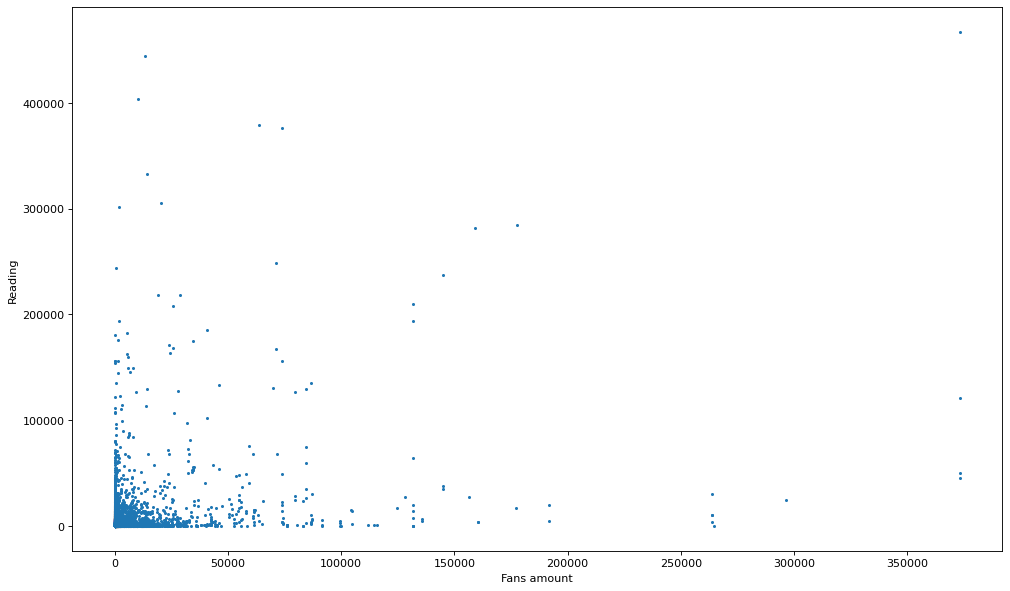

In [96]:
x=data.writerFan
y=data.blog_read_count
plt.figure(figsize=(15,9),dpi=80)
plt.xlabel('Fans amount')
plt.ylabel('Reading')
plt.scatter(x,y,s=3)

绝大多数数据在图的左下角，因此还需要进一步放大查看。不过对于比较极端的两条轴周围的数据，我们可以说明：有时热门博主也能写出超冷门帖子，而有的博主热度不高但能写出被许多人观摩的热门帖。

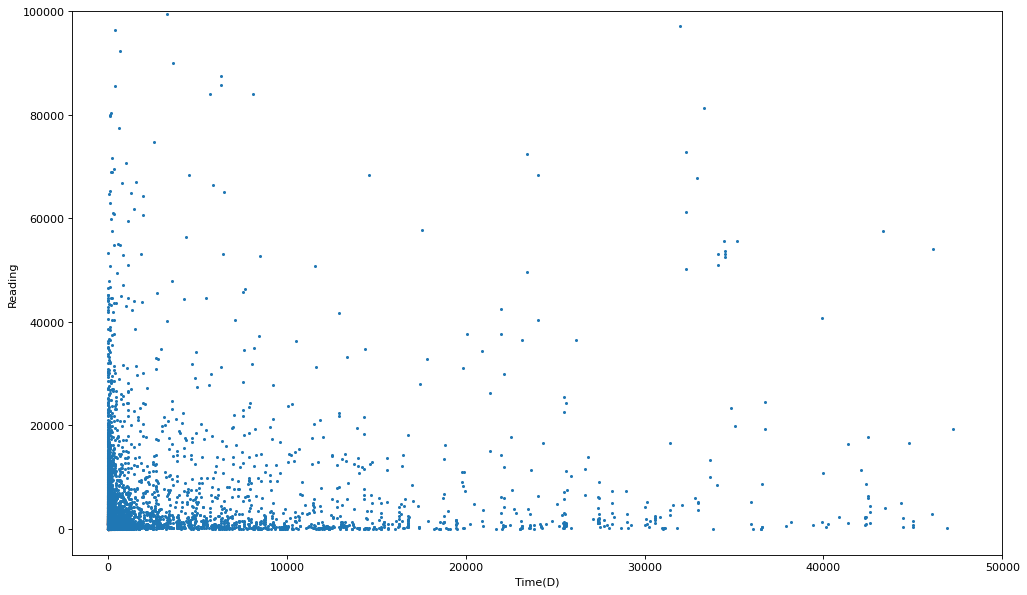

In [103]:
plt.figure(figsize=(15,9),dpi=80)
plt.xlabel('Fans amount')
plt.ylabel('Reading')
plt.xlim(-2000,50000)
plt.ylim(-5000,100000)
plt.scatter(x,y,s=3)

作图仍然呈现左下角和两条坐标轴周围密集，中部过度稀疏的状态，我们进一步放大。

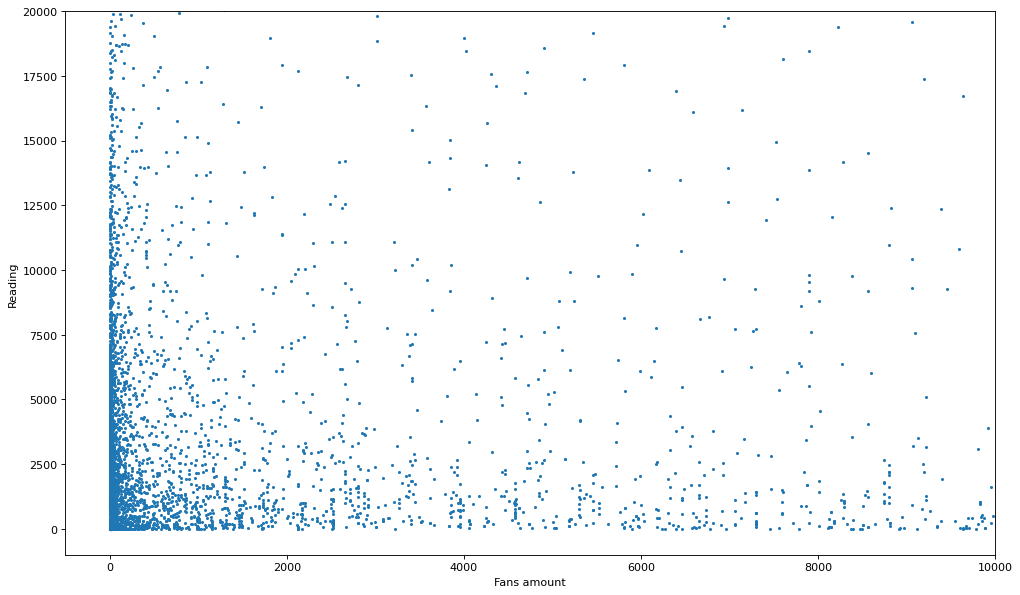

In [106]:
plt.figure(figsize=(15,9),dpi=80)
plt.xlabel('Fans amount')
plt.ylabel('Reading')
plt.xlim(-500,10000)
plt.ylim(-1000,20000)
plt.scatter(x,y,s=3)

好了，现在能看清一些了。首先，左下角的低阅读低粉丝量仍然非常密集，这和绝大多数平台的状态也当然是相似的————平台上充斥着大量存在感低的朋友发一些存在感低的帖子。不过在这张图中，y轴（阅读量）周边样本的聚集程度还是高于x轴（粉丝数量）的。因此，总体上来说，小透明博主写出精华帖的概率还是比大牛博主发低阅读量帖子的概率要大~攒粉不容易啊……大概要有很多篇精华帖才能让粉丝数量逐步提升吧。

#### 三、不同语言标签重叠数量及可能的原因探究

In [107]:
sql='SELECT cpp,csharp,java,javascript,php,sqll,python FROM `blog_bloginfo`;'
df2=pd.read_sql(sql,conn)

d:\Desktop\comingSpring\meworker\python_yeah\ana\envs\py38\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


利用一些简单的线性代数知识（？）我们可以得到不同的语言标签在本样本中的重叠数量，从而推测它们之间的联系。

In [134]:
import matplotlib.colors 
import matplotlib.ticker
import matplotlib.pyplot as plt

array1=np.array(df2)
array2=array1.T
result=np.matmul(array2,array1)
np.savetxt('output.csv', result, delimiter=',')

<img src="./Result.jpg" width="60%">

（因为弄了大半天都没有在matplotlib里成功弄出来而ddl太近了所以只能用excel先画出来，求助教不杀……之后一定会搞懂matplotlib咋画这种图的……）

如图所示，从已有样本的关联度来看，这些语言之间还是存在一定联系的。而这种联系在文字表达上体现就如图所示。关联最密切的当属SQL-Java与PHP-SQL，这里侧面说明了SQL是一种使用非常广泛的数据库语言，不论和其他哪种语言都存在一定的关联，也就是说用其他语言做project的时候要用到数据库，那么SQL很多时候就绕不开。

关联密切的第二层次则是SQL-Python，C++-Python和Java-C++。SQL自不必说，而C++和剩下两种语言关联紧密，可能是因为Python的很多语言实现来自于C++，而Java则是一门和C++比较类似的语言（不知道，学Java的室友说的），可能会被博主拿来进行对比。